# Tutorial 1 : using the `qmat.lagrange` module

📜 _The_ `LagrangeApproximation` _class from the_ `qmat.lagrange` _module is a multi-purpose class to perform interpolation, integration or derivative approximation from a given set of 1D points._
_It is based on the Barycentric Lagrange interpolation theory, originally developed by Joseph-Louis Lagrange around 1795, and widely popularized by the paper of Jean-Paul Berrut ahd Llyod N. Trefethen : ["Barycentric Lagrange interpolation"](https://doi.org/10.1137/S0036144502417715)._

The main concept behind the `LagrangeApproximation` class is to precompute the barycentric weights for any provided set of points, then use them to generate value-independent matrices used later to compute approximations (interpolation, integration or derivative) from values vectors.

## Basic usage

Whatever the application, one needs a set of $M$ interpolation points ${\bf t}$ to instantiate a `LagrangeApproximation` object :

In [1]:
from qmat.lagrange import LagrangeApproximation

points = [0, 0.25, 0.5, 0.75, 1]
approx = LagrangeApproximation(points)

print(f"points  : {approx.points} (size: {approx.nPoints})")
print(f"weights : {approx.weights}")

points  : [0.   0.25 0.5  0.75 1.  ] (size: 5)
weights : [ 10.66666667 -42.66666667  64.         -42.66666667  10.66666667]


When initializing the `approx` variable, weights are already pre-computed and stored as attribute, along with the given points. 

> 💡 There is no constrains on the lower and upper bound for the points, but they **have to be sorted in ascending order** (if not, an error is raised).

### Interpolation

Let's interpolate a function on $S$ "fine" points ${\bf s}$, knowing "coarse" function values ${\bf f_t}$ on the interpolated points.
We can generate the $P$ matrix of shape $(S,M)$ that allows to interpolate the function values on the $S$ fine points :

$$
{\bf f_s} = P {\bf f_t},
$$

simply like this :

In [2]:
import numpy as np

finePoints = np.linspace(0, 1, num=200)
P = approx.getInterpolationMatrix(finePoints)

Then, $P$ can be stored and use for multiple interpolations on the same points :

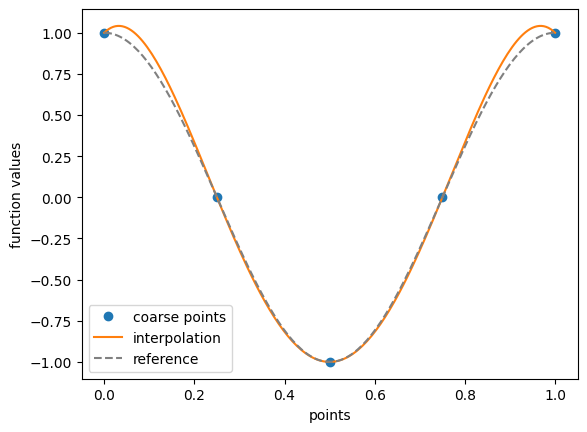

In [3]:
fValues = np.cos(2*np.pi*approx.points)
interpolated = P @ fValues
reference = np.cos(2*np.pi*finePoints)

# Some plotting for demonstration
import matplotlib.pyplot as plt
plt.plot(points, fValues, "o", label="coarse points")
plt.plot(finePoints, interpolated, label="interpolation")
plt.plot(finePoints, reference, "--", color="gray", label="reference")
plt.xlabel("points"); plt.ylabel("function values"); plt.legend();

> 💡 Note that there is a visible error with the reference close to the boundary (Runge effect), which is due to the choice of interpolated points. 
> Those can be selected differently to improve the quality of the interpolation, see the [tutorial on node generation ...](./22_nodes.ipynb).

### Integration

Let's integrate a function to on $N$ intervals $(t_{n}^{beg}, t_{n}^{end})$, knowing function values ${\bf f_t}$ on the interpolated points.
We can generate the $I$ matrix of shape $(N,M)$ that allows to integrate the interpolant polynomial on the $N$ 
intervals and approximate it with $int[f]_N$:

$$
int[f]_N = I {\bf f_t},
$$

where $I$ is a $(N,M)$ quadrature matrix generated like this :

In [4]:
tBeg = 0
tEnd = np.linspace(0, 1, num=200)

intervals = [(tBeg, t) for t in tEnd]
I = approx.getIntegrationMatrix(intervals)

Then, $I$ can be stored and used for multiple integrations on the same points :

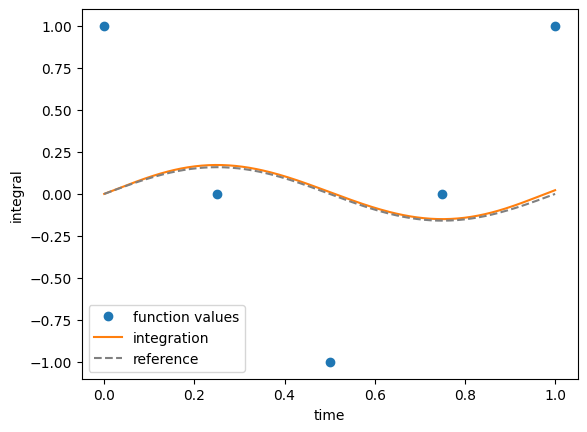

In [5]:
fValues = np.cos(2*np.pi*approx.points)

integrated = I @ fValues
reference = 1/(2*np.pi)*np.sin(2*np.pi*tEnd)

# Some plotting for demonstration
plt.plot(points, fValues, "o", label="function values")
plt.plot(tEnd, integrated, label="integration")
plt.plot(tEnd, reference, "--", color="gray", label="reference")
plt.xlabel("time"); plt.ylabel("integral"); plt.legend();

> 💡 Integration errors increases with time, which is expected since we start the integration at $t=0$.

### Differentiation

Let's compute the derivative matrix for a stencil of $N$ points, allowing to approximate the derivative of any 1D function known on the $N$ stencil points.
We can generate this $D$ matrix like this :

In [6]:
D = approx.getDerivativeMatrix()

Considering the chosen points here $[0, 0.25, 0.5, 0.75, 1]$, we can then retrieve the classical centered fourth order finite-difference coefficients, looking at the center row of this matrix (derivative for point $0.5$) :

In [7]:
np.allclose(D[2]*0.25, [1/12, -2/3, 0, 2/3, -1/12])

True

Similarly, second derivative coefficients can be retrieved like this :

In [8]:
D2 = approx.getDerivativeMatrix(order=2)
np.allclose(D2[2]*(0.25)**2, [-1/12, 4/3, -5/2, 4/3, -1/12])

True

Or simply using a matrix power of the original $D$ matrix :

In [9]:
np.allclose(D2, D @ D)

True

> 💡 Note that we cannot retrieve the function derivative on any points, as we did for the interpolation. However, we can still use the interpolation matrix $P$ determined later, and combine with the derivative matrix $D$ :

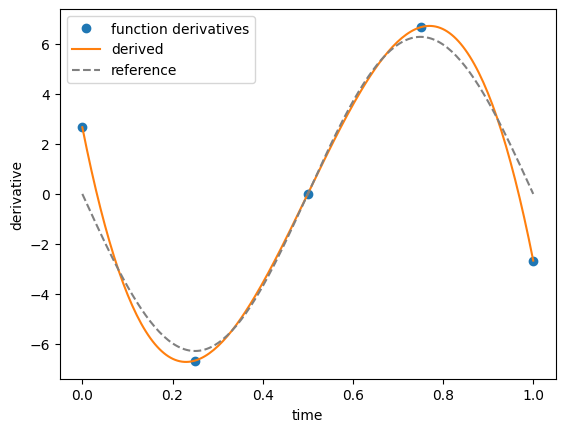

In [10]:
fValues = np.cos(2*np.pi*approx.points)

derived = P @ D @ fValues
reference = -2*np.pi*np.sin(2*np.pi*finePoints)

# Some plotting for demonstration
plt.plot(points, D @ fValues, "o", label="function derivatives")
plt.plot(finePoints, derived, label="derived")
plt.plot(finePoints, reference, "--", color="gray", label="reference")
plt.xlabel("time"); plt.ylabel("derivative"); plt.legend();

But this approach has some accuracy issue, especially on points close to the boundary, which is one reason why backward or forward finite differences are usually not used in practical applications ...

## Handling duplicated points

📜 _While the base theory behind Barycentric Interpolation required all points to be unique, the `LagrangeApproximation` class can also take interpolation points with duplicates._

Let's consider the following example :

In [11]:
points = [0, 0.5, 1, 1, 1.25, 1.75, 2, 2, 2.5, 3]

Those corresponds to fine points, that we could need for instance to interpolate those on some "coarse" points :

In [12]:
coarse = [0, 1.5, 3]

While the values for $0$ and $3$ can easily be retrieve from the fine points, the value for $1.5$ is more problematic, as two different function values could be taken for $1$ and $2$.

The `LagrangeApproximation` handles that automatically by taking **per default** the incoming value at the left, i.e taking the first value given for $1$ and $2$ and ignoring the next one(s). This can be seen on the interpolation matrix :

In [13]:
P = LagrangeApproximation(points).getInterpolationMatrix(coarse)

print(f"fine points = {points}")
print(f"P (transpose) = \n{P.T}")
print(f"coarse points = {coarse}")

fine points = [0, 0.5, 1, 1, 1.25, 1.75, 2, 2, 2.5, 3]
P (transpose) = 
[[ 1.         -0.00142857 -0.        ]
 [-0.          0.02        0.        ]
 [ 0.         -0.25       -0.        ]
 [ 0.          0.          0.        ]
 [-0.          0.73142857  0.        ]
 [ 0.          0.73142857 -0.        ]
 [-0.         -0.25        0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.02       -0.        ]
 [-0.         -0.00142857  1.        ]]
coarse points = [0, 1.5, 3]


For the coarse points $0$ and $3$ (first and last column), the interpolation simply corresponds to a copy the associated function values.
But for the coarse point $1.5$, the class build an interpolation stencil that has a coefficient for the first fine value for $1$ and $2$, and zero for the others.

$P$ is similar as the matrix obtained without duplicated points :

In [14]:
LagrangeApproximation(points).getInterpolationMatrix(coarse, duplicates=False).T

array([[ 1.        , -0.00142857, -0.        ],
       [-0.        ,  0.02      ,  0.        ],
       [ 0.        , -0.25      , -0.        ],
       [-0.        ,  0.73142857,  0.        ],
       [ 0.        ,  0.73142857, -0.        ],
       [-0.        , -0.25      ,  0.        ],
       [ 0.        ,  0.02      , -0.        ],
       [-0.        , -0.00142857,  1.        ]])

... except there are some zeros columns (rows in the transposed representation) added to the final matrix with duplicates.

Additionally duplicated values can be handled differently by **using the right values** rather than the left ones (default) :

In [15]:
P = LagrangeApproximation(points, duplicates="USE_RIGHT").getInterpolationMatrix(coarse)

print(f"fine points = {points}")
print(f"P (transpose) = \n{P.T}")
print(f"coarse points = {coarse}")

fine points = [0, 0.5, 1, 1, 1.25, 1.75, 2, 2, 2.5, 3]
P (transpose) = 
[[ 1.         -0.00142857 -0.        ]
 [-0.          0.02        0.        ]
 [ 0.          0.          0.        ]
 [ 0.         -0.25       -0.        ]
 [-0.          0.73142857  0.        ]
 [ 0.          0.73142857 -0.        ]
 [ 0.          0.          0.        ]
 [-0.         -0.25        0.        ]
 [ 0.          0.02       -0.        ]
 [-0.         -0.00142857  1.        ]]
coarse points = [0, 1.5, 3]


... here the zeros coefficients are simply applied to the first duplicated values in the interpolation matrix.

> 📣 The same behavior is also applied for the `getIntegrationMatrix` and `getDerivativeMatrix` methods, and for each of those using the parameter `duplicates=False` return the matrix as if there was not duplicates in the points (default is `True`).